# Summary/Abstract

CIS 3330

Instructor: Dr. Villacis Calderon


In this business analytics project, I am exploring the economy behavior in El Paso due to the COVID-19 Pandemic, and the long terms effects by using a mix of descriptive and predictive statistics. The objective is to figure out when and how the economy recovered and see what we can learn from it. I am using several metrics to measure the economy health, including population spending, COVID metrics (case rate and vaccine rate), employment numbers, mobility numbers, and job postings. A report derived from Checkpoint B is available in the repository and it contains the data cleaning aspect of the project. The following code and findings is specific to the analysis section based on the feedback for abstraction I received.   

# Descriptive Analytics: Correlation, ANOVA, Time-Series Plots

In [17]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
pd.options.mode.chained_assignment = None  # Removing an annoying warning

In [18]:
# Reading File
df = pd.read_csv("final_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23092 entries, 0 to 23091
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            23092 non-null  object 
 1   cityid              23092 non-null  int64  
 2   spend_all           17338 non-null  float64
 3   spend_inperson      17338 non-null  float64
 4   bg_posts            2979 non-null   float64
 5   new_case_rate       21936 non-null  float64
 6   new_vaccine_rate    10777 non-null  float64
 7   gps_away_from_home  18482 non-null  float64
 8   emp_incq1           23092 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.6+ MB


In [19]:
corr = df.loc[:, df.columns!='cityid'].corr(numeric_only=True) # using .loc to remove cityid, which is just an identifier, not a number

## Heatmap

<Axes: >

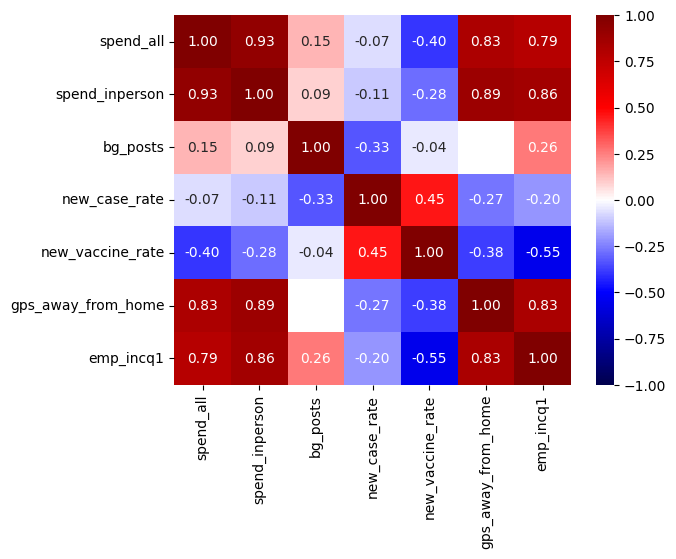

In [20]:
sns.heatmap(corr, annot=True, fmt='.2f', vmax=1, vmin=-1, cmap = 'seismic')

We can infer some interesting things from the heatmap. One is that there was a clear inverse relationship between spending and  vaccine rates, alluding that the severity of certain waves lessened desire or ability to spend more money. Similarly, there were less people being employed and people stayed more time at home when vaccine and cases rate were high. Finally, very strong positive correlations are observed between spending and employment rates & time away from home.   
White rectangles show NA correlation because dates where one was recorded, the other one wasn't.   

## Boxplot

<Axes: >

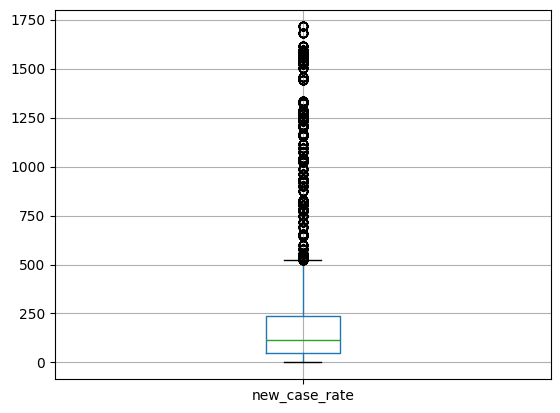

In [21]:
df.boxplot(column='new_case_rate')

This boxplot shows an extreme amount of statistical outliers, but make sense when considering the pattern of covid seasonal surges. I included this plot because this knowledge became important when choosing my predictive analytics model, as linear regression is very sensitive to outliers but random forests are robust in this regard. 

## Scatter Plots / Time Series

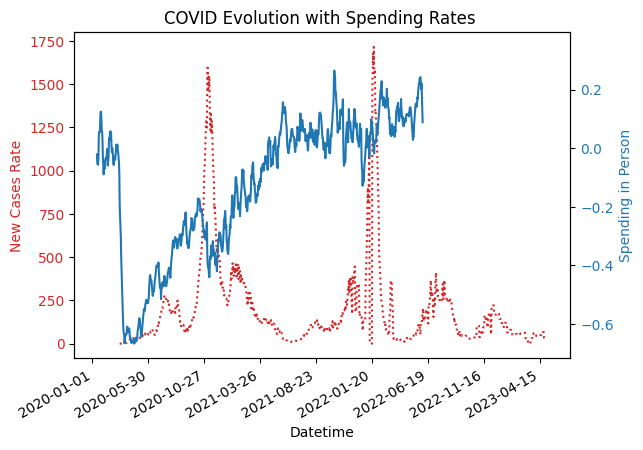

In [22]:
fig, ax1 = plt.subplots()

# First time series on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('New Cases Rate', color=color)
ax1.plot(df['datetime'], df['new_case_rate'], linestyle='dotted', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis on the right for the second time series
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Spending in Person', color=color)
ax2.plot(df['datetime'], df['spend_inperson'], linestyle='solid', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title('COVID Evolution with Spending Rates ')
plt.gcf().autofmt_xdate()
ax1.set_xticks(ax1.get_xticks()[::150])
plt.show()

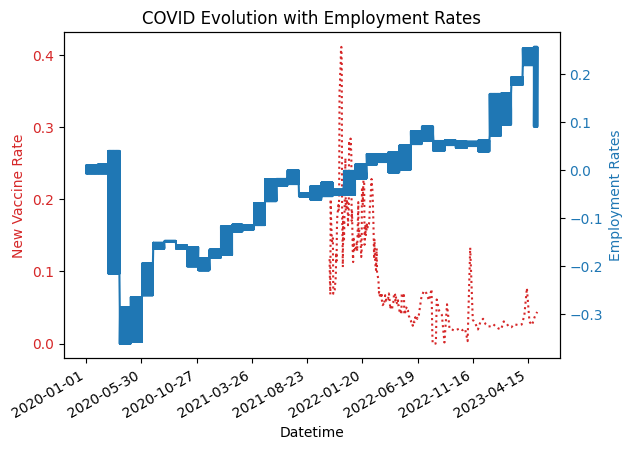

In [23]:
fig, ax1 = plt.subplots()

# First time series on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('New Vaccine Rate', color=color)
ax1.plot(df['datetime'], df['new_vaccine_rate'], linestyle='dotted', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis on the right for the second time series
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Employment Rates', color=color)
ax2.plot(df['datetime'], df['emp_incq1'], linestyle='solid', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title('COVID Evolution with Employment Rates')
plt.gcf().autofmt_xdate()
ax1.set_xticks(ax1.get_xticks()[::150])
plt.show()

In both of these time series, we can observe the inverse relationship between spending and employment compared to covid metrics. Notably, we see that because vaccines came midway through the pandemic, employment was returning to normal levels by then (2022). This explains the relatively strong negative correlation between them. We can also see the slight decrease in spending around the time when there were case peaks.

## ANOVA

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [25]:
df_anova = df.dropna(subset=['spend_all', 'spend_inperson', 'new_case_rate', 'gps_away_from_home', 'emp_incq1'])

formula = 'spend_all ~  spend_inperson + new_case_rate + gps_away_from_home + emp_incq1'
model = ols(formula, df_anova).fit()

# Create the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)

                       sum_sq       df             F         PR(>F)
spend_inperson      25.193188      1.0  12500.958671   0.000000e+00
new_case_rate        0.816310      1.0    405.056287   5.606730e-89
gps_away_from_home   1.055260      1.0    523.624278  4.779323e-114
emp_incq1            0.094119      1.0     46.702326   8.563602e-12
Residual            32.004987  15881.0           NaN            NaN


ANOVA Table shows that there is statistically significant evidence to say that COVID cases, time at home, and employment rates all affected spending. 

# Predictive Analytics: Random Forest Regression 

In [26]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")



### Making a random forest regression model to predict the case rate based on the time people spent away from home

In [27]:
df_lr = df.dropna(subset=['gps_away_from_home', 'new_case_rate'])

X = df_lr[['gps_away_from_home']]
y = df_lr['new_case_rate']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

Accuracy = r2_score(y_test,y_pred)
print("Accuracy of the model is %.2f R-2 Squared" %Accuracy)


Accuracy of the model is 0.67 R-2 Squared


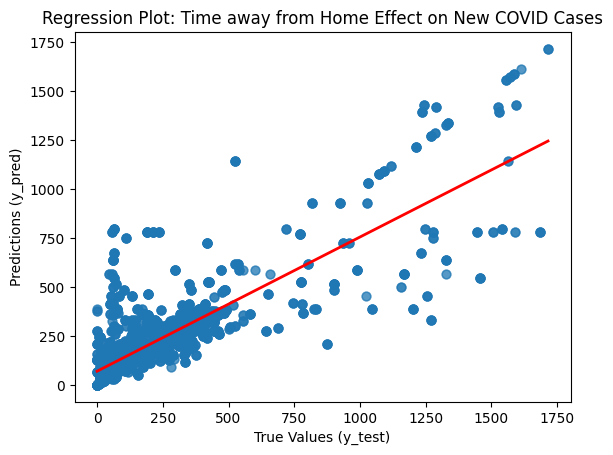

In [28]:
sns.regplot(x=y_test, y=y_pred, fit_reg=True, ci=None, scatter_kws={'s': 40, 'alpha': 0.5}, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('True Values (y_test)')
plt.ylabel('Predictions (y_pred)')
plt.title('Regression Plot: Time away from Home Effect on New COVID Cases')
plt.show()

The scatter plot of predicted versus true values shows a strong linear trend, indicating that the Random Forest model effectively captured the inversely linear relationship between the time that people spent away from home and the COVID new case rate. While testing the model with two independent variables (spending in person + gps away from home), it overfitted to a perfectly linear relationship, stemming from the fact that they have a strong correlation, so I removed it to the most important one after doing feature importance analysis. Moving on, a few outliers exist, particularly for higher 'new_case_rate' values, where the model tends to underestimate. Overall, the model performs well, with an R-squared of 0.67, indicating that 67% of the variability in 'new_case_rate' is explained by the model. 

## Forecast for Job Metrics | Using Tableau 

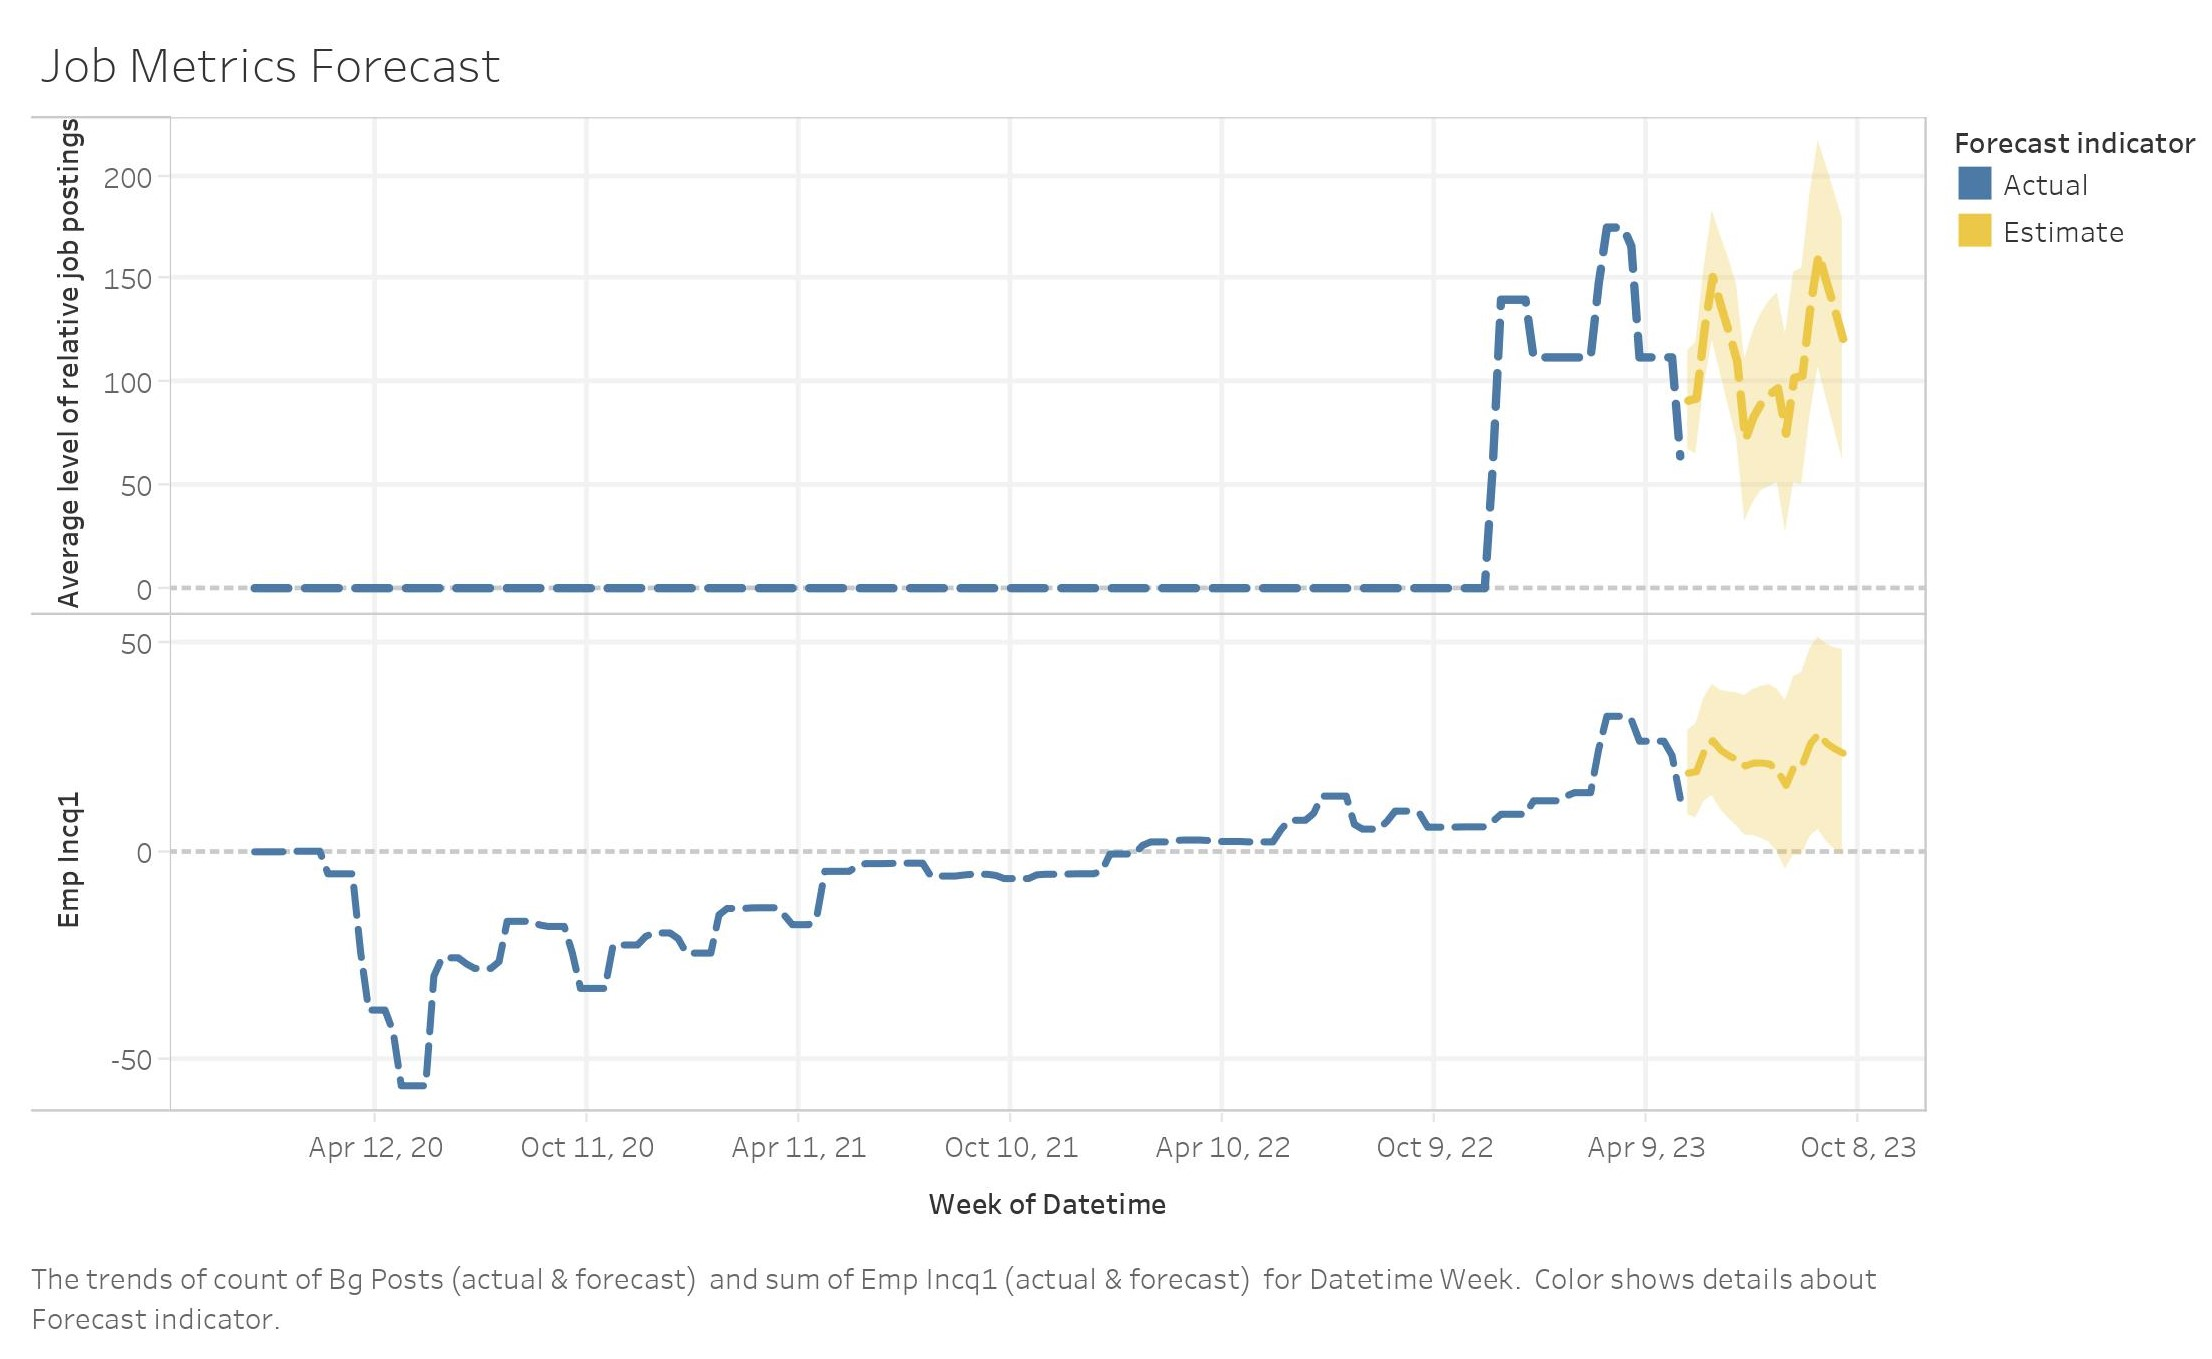

In [29]:
from PIL import Image
from IPython.display import display
img = Image.open('forecast2.jpg')
display(img)

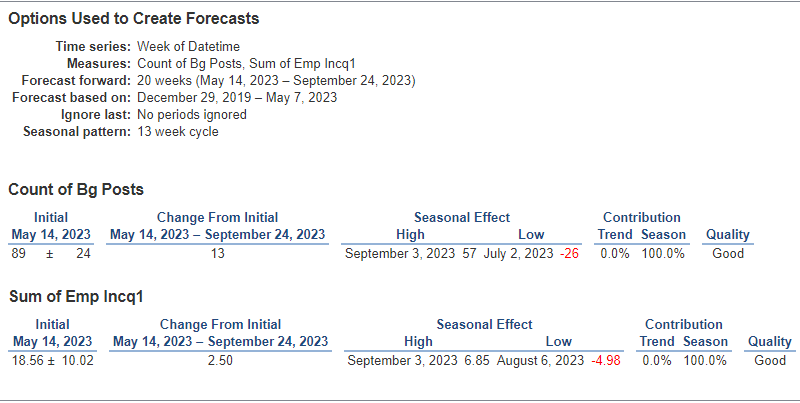

In [30]:
img = Image.open('summary.png')
display(img)

I wanted to do a forecast of the job postings and employment rates from the data I had. In the case of job postings, since the data spans less time the forecast might not be as accurate. For the the bottom quartile income wise (well below the poverty line) population, it's very likely that the rate of employment will stay above the rate it was January 2020 (this is what the rate means based from the dataset dictionary). The description of the forecast above is provided to see specifics of the model. It identified a pattern of a 13 week cycle in its seasonality.    

# Findings

## Overall, the analysis of COVID data and economy trackers showed a clear turnaround in the financial state of El Paso during the pandemic. This turnaround, based on the findings, is around January 2022. This is exhibited by: 
## 1. The employement rate of the bottom quartile of the population, which is the backbone of the working force, reached pre-pandemic levels in January of 2022. 
## 2. Spending in person was not affected by the second "wave" of the pandemic in early 2022. Most likely due to state and national policies on lifting restrictions (or rather not implementing them again) for movement and capacity of those in-person services. 

## The predictive analytics section displayed how time away from the house, using anonymized GPS data from Google, could reasonably predict the amount of new cases of the coronavirus. This is just an interesting fact of the biological phenomenon of how contagious diseases work and how they can be quantified in real life situations.
